In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from decimal import Decimal 
import datetime as dt


In [5]:
df = pd.read_csv('patient_transaction.csv')
df['Date'] = pd.to_datetime(df['Date'])
df


,Patient ID,Age,Treatment,Duration,Date,Provider Dentist,Price,Material Cost
0,Patient_664,37,Root canal 4,405.0,2018-01-01,RE,2108.0,634
1,Patient_681,70,RC Major Package - Back,635.0,2018-01-01,RE,2159.0,649
2,Patient_440,28,"6 Bridge treatment 3A,3P",330.0,2018-01-01,RE,5019.0,1504
3,Patient_351,51,Refresh (New),45.0,2018-01-03,RE,50.0,15
4,Patient_408,45,Clinical Occlusal Analysis,5.0,2018-01-03,CQ,295.0,89
...,...,...,...,...,...,...,...,...
5917,Patient_060,66,Metal partial denture treatment of lower parti...,330.0,2023-12-27,WS,1450.0,436
5918,Patient_845,71,Major fill Back Teeth,120.0,2023-12-27,WS,387.0,117
5919,Patient_985,74,Denture Reparation (Replacing/adding clasp to ...,95.0,2023-12-27,CQ,243.0,73
5920,Patient_287,54,Oral Health Index - Advance Hygiene (Add Time)...,125.0,2023-12-29,RE,311.0,94


In [43]:
# Computing the summary data (Recency, Frequency, monetary and tenure)
df_rfmt = summary_data_from_transaction_data(transactions = df, 
                                         customer_id_col = 'Patient ID', 
                                         datetime_col = 'Date', 
                                         monetary_value_col = 'Price')
df_rfmt.head()

,frequency,recency,T,monetary_value
Patient ID,,,,
Patient_001,5.0,1728.0,1810.0,427.600000
Patient_002,3.0,1865.0,2125.0,3908.666667
Patient_003,5.0,1935.0,2068.0,1204.200000
Patient_004,5.0,1892.0,1897.0,1320.200000
Patient_005,2.0,1297.0,1535.0,1790.000000


In [44]:
# size of the data 
diff_time = df['Date'].max() - df['Date'].min() 
diff_time

Timedelta('2189 days 00:00:00')

In [45]:
# Getting the ending date of the calibration period. 
end_date_cal = df['Date'].min() + dt.timedelta(days=1500)
end_date_obs = end_date_cal + (diff_time - dt.timedelta(days=1500))

In [46]:
df_rfmt_cal = calibration_and_holdout_data(transactions=df, 
                                          customer_id_col="Patient ID",
                                          datetime_col = "Date", 
                                          calibration_period_end=end_date_cal,
                                          observation_period_end= end_date_obs)
df_rfmt_cal

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Patient ID,,,,,
Patient_001,4.0,855.0,1121.0,1.0,689.0
Patient_002,1.0,114.0,1436.0,2.0,689.0
Patient_003,2.0,679.0,1379.0,3.0,689.0
Patient_004,2.0,1036.0,1208.0,3.0,689.0
Patient_005,1.0,661.0,846.0,1.0,689.0
...,...,...,...,...,...
Patient_994,3.0,777.0,1442.0,1.0,689.0
Patient_995,5.0,774.0,961.0,3.0,689.0
Patient_996,4.0,673.0,1340.0,2.0,689.0


In [47]:
l2_coefs = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
l2_list = []
rmse_list = []
for coef in l2_coefs :
    # Fitting the model using the calibration dataset.
    model = BetaGeoFitter(penalizer_coef=coef)
    model.fit(df_rfmt_cal['frequency_cal'], 
        df_rfmt_cal['recency_cal'], 
        df_rfmt_cal['T_cal'])
    # Predicting the frequency for the holdout period for all customers. 
    pred_freq = pd.DataFrame(model.predict(df_rfmt_cal['duration_holdout'], 
                                 df_rfmt_cal['frequency_cal'], df_rfmt_cal['recency_cal'], df_rfmt_cal['T_cal']), columns=['pred_frequency']).reset_index()
    # Merging the two dataframes and dropping NaN values. 
    new_df = df_rfmt_cal.reset_index().merge(pred_freq, on='Patient ID').dropna()

    # Computing the rmse score 
    rmse_score = np.sqrt(mean_squared_error(new_df['frequency_holdout'],new_df['pred_frequency']))
    l2_list.append(coef)
    rmse_list.append(rmse_score)

# Getting the results 
resl = pd.DataFrame(np.array(rmse_list), columns=['rmse_score'])\
             .merge(pd.DataFrame(np.array(l2_list), columns=['L2 coefs']), right_index=True, left_index=True)
resl

c:\Users\Zak\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Zak\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Zak\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Zak\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Zak\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Zak\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = geta

,rmse_score,L2 coefs
0,1.537506,0.3
1,1.548061,0.4
2,1.559009,0.5
3,1.566588,0.6
4,1.572512,0.7
5,1.577542,0.8
6,1.581917,0.9
7,1.585781,1.0


In [48]:
# Fitting the model using the calibration dataset.
model = BetaGeoFitter(penalizer_coef=0.80)
model.fit(df_rfmt_cal['frequency_cal'], 
        df_rfmt_cal['recency_cal'], 
        df_rfmt_cal['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 984 subjects, a: 0.00, alpha: 178.70, b: 0.00, r: 0.51>

c:\Users\Zak\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


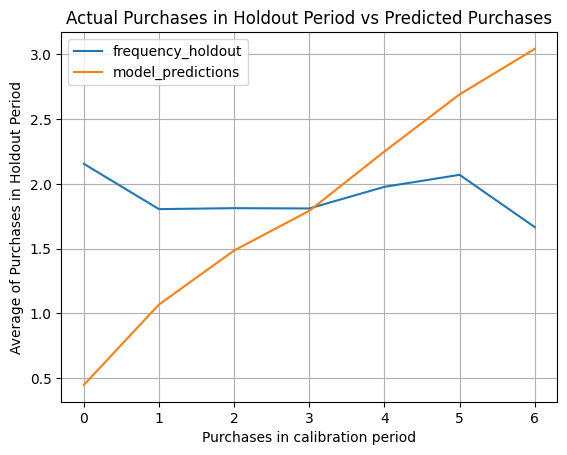

In [49]:
# Generate the plot
ax = plot_calibration_purchases_vs_holdout_purchases(model, df_rfmt_cal)

# Add grid to the plot
ax.grid(True)  # Enables the grid


plt.show()

### Gamma Gamma

In [50]:
# Predicting the number of purchases in the next 180 days for all customers.
df_rfmt['predicted_purchases'] = model.conditional_expected_number_of_purchases_up_to_time(180, 
                                                                                      df_rfmt['frequency'], 
                                                                                      df_rfmt['recency'], 
                                                                                      df_rfmt['T'])
df_rfmt.dropna(inplace=True)
# Getting rid of negative values.
df_rfmt = df_rfmt[df_rfmt['monetary_value']>0]
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases
Patient ID,,,,,
Patient_001,5.0,1728.0,1810.0,427.600000,0.498730
Patient_002,3.0,1865.0,2125.0,3908.666667,0.274265
Patient_003,5.0,1935.0,2068.0,1204.200000,0.441459
Patient_004,5.0,1892.0,1897.0,1320.200000,0.477827
Patient_005,2.0,1297.0,1535.0,1790.000000,0.263654
...,...,...,...,...,...
Patient_995,8.0,1410.0,1650.0,941.750000,0.837659
Patient_996,6.0,1885.0,2029.0,1249.166667,0.530790
Patient_997,5.0,1825.0,2008.0,2466.000000,0.453572


In [51]:
# Fitting the GammaGamma model 

gg_model = GammaGammaFitter(penalizer_coef = 0.10)
gg_model.fit(df_rfmt['frequency'], df_rfmt['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 991 subjects, p: 0.88, q: 0.14, v: 0.83>

In [52]:
df_rfmt['pred_monetary'] = gg_model.conditional_expected_average_profit(
        df_rfmt['frequency'],
        df_rfmt['monetary_value'])
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary
Patient ID,,,,,,
Patient_001,5.0,1728.0,1810.0,427.600000,0.498730,531.605528
Patient_002,3.0,1865.0,2125.0,3908.666667,0.274265,5795.797003
Patient_003,5.0,1935.0,2068.0,1204.200000,0.441459,1496.725798
Patient_004,5.0,1892.0,1897.0,1320.200000,0.477827,1640.884891
Patient_005,2.0,1297.0,1535.0,1790.000000,0.263654,3499.180405
...,...,...,...,...,...,...
Patient_995,8.0,1410.0,1650.0,941.750000,0.837659,1072.827701
Patient_996,6.0,1885.0,2029.0,1249.166667,0.530790,1492.201750
Patient_997,5.0,1825.0,2008.0,2466.000000,0.453572,3064.828757


In [53]:
# drop the negative values
df_rfmt = df_rfmt[df_rfmt['pred_monetary']>0]
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary
Patient ID,,,,,,
Patient_001,5.0,1728.0,1810.0,427.600000,0.498730,531.605528
Patient_002,3.0,1865.0,2125.0,3908.666667,0.274265,5795.797003
Patient_003,5.0,1935.0,2068.0,1204.200000,0.441459,1496.725798
Patient_004,5.0,1892.0,1897.0,1320.200000,0.477827,1640.884891
Patient_005,2.0,1297.0,1535.0,1790.000000,0.263654,3499.180405
...,...,...,...,...,...,...
Patient_995,8.0,1410.0,1650.0,941.750000,0.837659,1072.827701
Patient_996,6.0,1885.0,2029.0,1249.166667,0.530790,1492.201750
Patient_997,5.0,1825.0,2008.0,2466.000000,0.453572,3064.828757


In [54]:
# Predicting the CLV.
df_rfmt['CLV'] = gg_model.customer_lifetime_value(
    model,
    df_rfmt['frequency'],
    df_rfmt['recency'],
    df_rfmt['T'],
    df_rfmt['monetary_value'],
    time = 6,# In months 
    )
df_rfmt 

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV
Patient ID,,,,,,,
Patient_001,5.0,1728.0,1810.0,427.600000,0.498730,531.605528,256.090370
Patient_002,3.0,1865.0,2125.0,3908.666667,0.274265,5795.797003,1535.399681
Patient_003,5.0,1935.0,2068.0,1204.200000,0.441459,1496.725798,638.219529
Patient_004,5.0,1892.0,1897.0,1320.200000,0.477827,1640.884891,757.332381
Patient_005,2.0,1297.0,1535.0,1790.000000,0.263654,3499.180405,891.125660
...,...,...,...,...,...,...,...
Patient_995,8.0,1410.0,1650.0,941.750000,0.837659,1072.827701,868.030556
Patient_996,6.0,1885.0,2029.0,1249.166667,0.530790,1492.201750,765.047260
Patient_997,5.0,1825.0,2008.0,2466.000000,0.453572,3064.828757,1342.733921
